* * *
<pre> NYU Paris            <i> Machine Learning - Summer 2023 </i></pre>
* * *


<h1 align="center"> Lab: Dimension Reduction </h1>

<pre align="left"> June 13th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goals:
- Understand PCA deeply and see when it can be useful or not
- Evaluate other dimension reduction methods

In [1]:
import numpy as np
from matplotlib import pyplot as plt

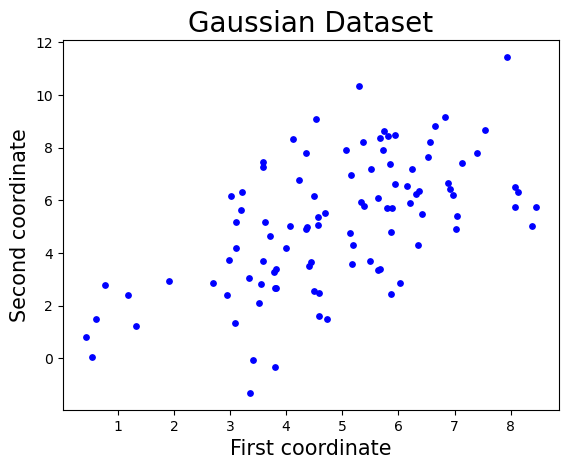

In [2]:
# Sample one dataset with (correlated) Gaussian distribution
np.random.seed(0)

# Size of data
n_samples = 100
n_dim = 2

# Mean vector of the dataset
mean = 5 *  np.ones(n_dim)

# Sample covariance matrix from a Wishart distribution
temp = np.random.randn(n_dim, n_dim)
cov = temp@temp.T

X = np.random.multivariate_normal(mean, cov, size=n_samples)

plt.scatter(X[:, 0], X[:, 1], s=15, c='b')
plt.xlabel('First coordinate', size=15)
plt.ylabel('Second coordinate', size=15)
plt.title('Gaussian Dataset', size=20)
plt.show()

### Question 1:

Implement your own PCA algorithm.

In [3]:
class MyPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components


    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

        #sort the eigenvalues in descending order
        sorted_index = np.argsort(eigen_values)[::-1]

        self.eigenvalues = eigen_values[sorted_index]

        #similarly sort the eigenvectors
        self.eigenvectors = eigen_vectors[:, sorted_index]
        self.eigenvector_subset = self.eigenvectors[:, :self.n_components]


    def transform(self, Z):
        Z_centered = Z - self.mean
        # Project the data onto the principal components (eigenvectors)
        return np.dot(Z_centered, self.eigenvector_subset)

### Question 2

Apply PCA on the Gaussian dataset

In [4]:
pca = MyPCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

### Question 3

Verify that your transformed data are decorrelated. What do you observe?

In [5]:
cov_pca = np.cov(X_pca.T)
print("Covariance matrix of PCA-transformed data:")
print(cov_pca)

Covariance matrix of PCA-transformed data:
[[ 7.78619202e+00 -7.28215362e-16]
 [-7.28215362e-16  1.67113936e+00]]


The transformed data is decorrelated since we have non zero diagonal and almost 0 in rest of the element in the covaraince matrix.

### Question 4

Visualize your transformed data after PCA.

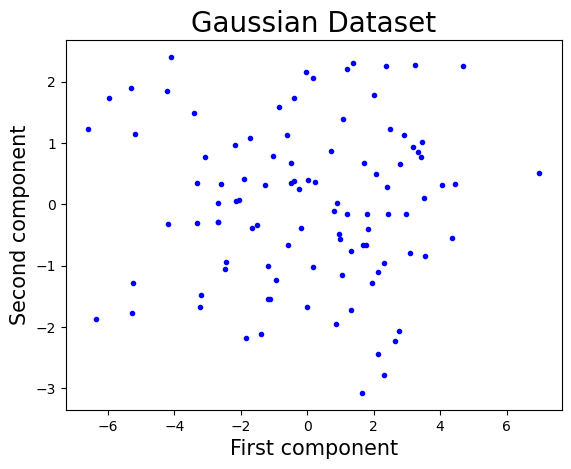

In [6]:
plt.scatter(X_pca[:,0],X_pca[:,1], color='b', marker='.')
plt.xlabel('First component', size=15)
plt.ylabel('Second component', size=15)
plt.title('Gaussian Dataset', size=20)
plt.show()

### Question 5

Compare your algorithm with the one in sklearn. You can check the covariance matrix of the transformed data. Is this the same than yours? What do you observe?

In [7]:
from sklearn.decomposition import PCA

In [8]:
sk_pca = PCA(n_components=2)
sk_pca.fit(X)
sk_X_pca = pca.transform(X)
sk_cov_pca = np.cov(sk_X_pca.T)
print("Covariance matrix of PCA-transformed data:")
print(sk_cov_pca)

Covariance matrix of PCA-transformed data:
[[ 7.78619202e+00 -7.28215362e-16]
 [-7.28215362e-16  1.67113936e+00]]


The covariance matrix is the same.

### Bonus Question

Compare the computational time of both algorithms, what do you observe? Why?

In [9]:
import time

In [24]:
X = np.random.multivariate_normal(mean, cov, size=10000)
for i in range(5):
    start_time = time.time()
    sk_pca = PCA(n_components=2)
    sk_pca.fit(X)
    sk_X_pca = sk_pca.transform(X)
    end_time = time.time()
    print("sklearn PCA fit + transform took {:.6f} seconds".format(end_time - start_time))
    
    start_time = time.time()
    pca = MyPCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    end_time = time.time()
    print("Custom PCA fit + transform took {:.6f} seconds".format(end_time - start_time))

sklearn PCA fit + transform took 0.001445 seconds
Custom PCA fit + transform took 0.001926 seconds
sklearn PCA fit + transform took 0.001009 seconds
Custom PCA fit + transform took 0.001195 seconds
sklearn PCA fit + transform took 0.001009 seconds
Custom PCA fit + transform took 0.000506 seconds
sklearn PCA fit + transform took 0.001507 seconds
Custom PCA fit + transform took 0.001007 seconds
sklearn PCA fit + transform took 0.000993 seconds
Custom PCA fit + transform took 0.001013 seconds


In some instances, our custom PCA is faster but in some, the sklearn is faster.

### Question 6

Let's apply the PCA on a (easy) classification real-world dataset. Apply PCA with 2 components and visualize the dataset with different colors for each class.

In [11]:
from sklearn import datasets

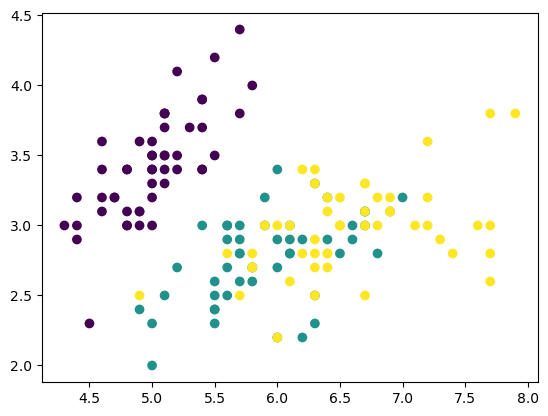

In [12]:
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris)
plt.show()

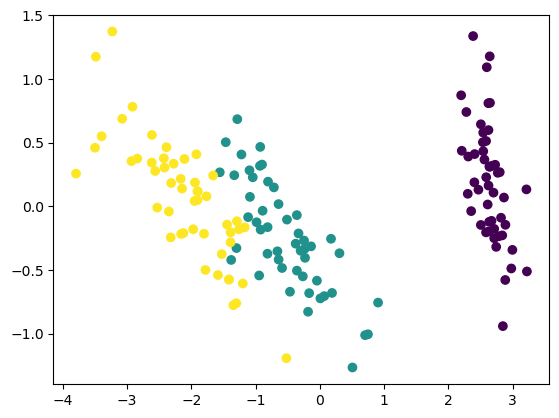

In [13]:
pca = MyPCA(n_components=2)
pca.fit(X_iris)
X_pca = pca.transform(X_iris)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_iris)
plt.show()

### Question 7

Use a KNN algorithm and perform it on the dataset. Use different combinations of parameters using the GridSearchCV function.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [15]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import itertools
import numpy as np

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

random_combos = random.sample(all_combinations, 10)

all_scores = []
best_score = -np.inf

for i, params in enumerate(random_combos, 1):
    knn = KNeighborsClassifier(**params)
    scores = cross_val_score(knn, X_iris, y_iris, cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    all_scores.append(mean_score)
    
    if mean_score > best_score:
        best_score = mean_score

    print(f"{i:02d}. Params: {params}, Accuracy: {mean_score:.4f}")

avg_accuracy = np.mean(all_scores)
print(f"\nAverage accuracy across 10 random configurations: {avg_accuracy:.4f}")
print(f"Best accuracy: {best_score:.4f}")

01. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1}, Accuracy: 0.9600
02. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1}, Accuracy: 0.9600
03. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}, Accuracy: 0.9733
04. Params: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'p': 1}, Accuracy: 0.9733
05. Params: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}, Accuracy: 0.9600
06. Params: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2}, Accuracy: 0.9667
07. Params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}, Accuracy: 0.9600
08. Params: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1}, Accuracy: 0.9600
09. Params: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'p': 1}, Accuracy: 0.9600
10. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto

### Question 8

Use a PCA first and then apply again the classification algorithm. Observe the best score, is the PCA improve the results? Which explanation can you give?

In [16]:
pca = MyPCA(n_components=2)
pca.fit(X_iris)
X_pca = pca.transform(X_iris)

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

keys, values = zip(*param_grid.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

random_combos = random.sample(all_combinations, 10)

all_scores = []
best_score = -np.inf

for i, params in enumerate(random_combos, 1):
    knn = KNeighborsClassifier(**params)
    scores = cross_val_score(knn, X_pca, y_iris, cv=5, scoring='accuracy', n_jobs=-1)
    mean_score = np.mean(scores)
    all_scores.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
    
    print(f"{i:02d}. Params: {params}, Accuracy: {mean_score:.4f}")

avg_accuracy = np.mean(all_scores)
print(f"\n Average accuracy across 10 runs: {avg_accuracy:.4f}")
print(f"Best accuracy: {best_score:.4f}")

01. Params: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}, Accuracy: 0.9533
02. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}, Accuracy: 0.9667
03. Params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}, Accuracy: 0.9600
04. Params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}, Accuracy: 0.9667
05. Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1}, Accuracy: 0.9733
06. Params: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'p': 2}, Accuracy: 0.9667
07. Params: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2}, Accuracy: 0.9667
08. Params: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}, Accuracy: 0.9600
09. Params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'p': 1}, Accuracy: 0.9533
10. Params: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'p': 

The best score and average score is still better or equal for the original data by a very tiny margin. But the accuracy we get even after reducing from 4 to 2 dimension is still remarkable as it is almost on par with the orignal dataset on different parametes of KNN.

### Question 9

How features influence the first components (in term of variance)? You can answer this question by inspecting the weights in the first component.

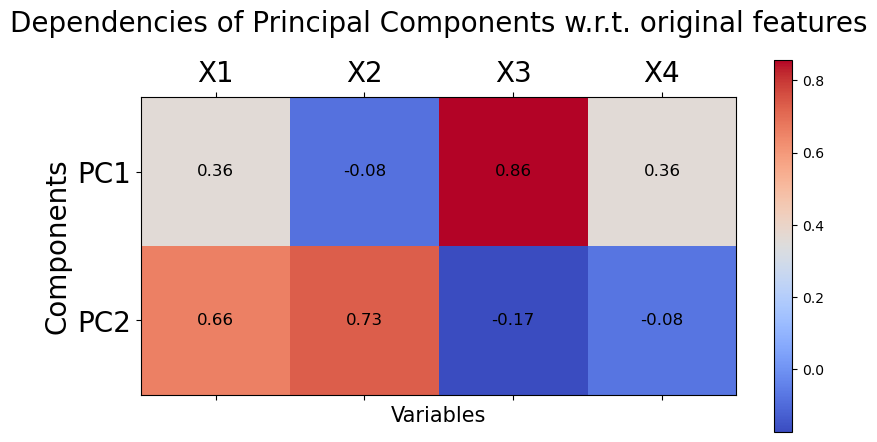

In [17]:
pca = PCA(n_components=2)
pca.fit(X_iris)
X_pca = pca.transform(X_iris)

plt.matshow(pca.components_, cmap='coolwarm') 
plt.ylabel('Components', size=20)
plt.xlabel('Variables', size=15)
for i in range(4):
    for j in range(2):
        plt.text(i, j, "%0.2f" % pca.components_[j, i], size=12, color='black', ha="center", va="center")
plt.colorbar()
xlabels = ['X1', 'X2', 'X3', 'X4']
plt.xticks(range(4), xlabels, size=20)
ylabels = ['PC1', 'PC2']
plt.yticks(range(2), ylabels, size=20)
plt.title('Dependencies of Principal Components w.r.t. original features', size=20, pad=20)
plt.show()

Analyzing the first component, X3 is the most influential feature in determining PC1 (since it has the highest postive weight of 0.86), and thus, most of the variance captured by PC1 comes from variations in X3.

### Bonus Question

Create a pipeline with KNN, classification trees, RandomForest and SVM. Perform the Question 7/8 for these 4 classifiers. What do you observe?

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC()
}

results_before_pca = {}
results_after_pca = {}

for model_name, model in models.items():
    pipeline_before = Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', model) 
    ])
    
    cv_scores_before = cross_val_score(pipeline_before, X_iris, y_iris, cv=5, scoring='accuracy')
    results_before_pca[model_name] = cv_scores_before.mean()

#After PCA
for model_name, model in models.items():
    pipeline_after = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)), 
        ('classifier', model)
    ])
    
    cv_scores_after = cross_val_score(pipeline_after, X_pca, y_iris, cv=5, scoring='accuracy')  # 5-fold cross-validation
    results_after_pca[model_name] = cv_scores_after.mean()

print("Accuracy Before PCA:")
for model_name, score in results_before_pca.items():
    print(f"{model_name} - Mean Accuracy: {score:.4f}")

print("\nAccuracy After PCA:")
for model_name, score in results_after_pca.items():
    print(f"{model_name} - Mean Accuracy: {score:.4f}")

Accuracy Before PCA:
KNN - Mean Accuracy: 0.9600
DecisionTree - Mean Accuracy: 0.9533
RandomForest - Mean Accuracy: 0.9600
SVM - Mean Accuracy: 0.9667

Accuracy After PCA:
KNN - Mean Accuracy: 0.9533
DecisionTree - Mean Accuracy: 0.8733
RandomForest - Mean Accuracy: 0.9200
SVM - Mean Accuracy: 0.9667


Even after reducing dimension to 2, SVM and KNN performed as good as it did with 4 dimensions. Decision Tree and Random Forest was slightly less accurate after PCA.

### Question 10

Time to apply PCA on a high dimensional dataset.

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
X_d = digits.data
y_d = digits.target

print(X_d.shape)

(1797, 64)


### Question 11

Now, you will have to reduce the dimension. The main question is: how to choose the number of components? Propose a method to determine a relevant number of components to keep.

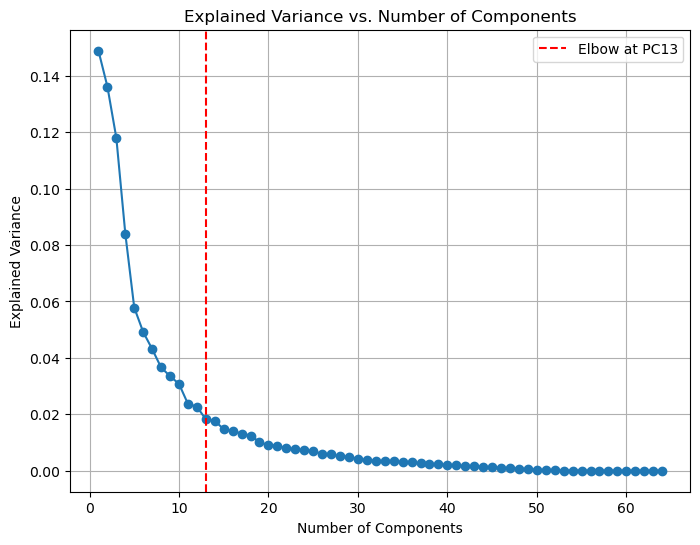

Elbow point is at principal component: 13


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_d)
explained_variance = pca.explained_variance_ratio_

n_points = len(explained_variance)
all_points = np.vstack((range(1, n_points + 1), explained_variance)).T

# First and last point
first_point = all_points[0]
last_point = all_points[-1]

line_vector = last_point - first_point
line_vector_norm = line_vector / np.linalg.norm(line_vector)

distances = []
for point in all_points:
    vector_from_first = point - first_point
    scalar_projection = np.dot(vector_from_first, line_vector_norm)
    projected_point = first_point + scalar_projection * line_vector_norm
    distance = np.linalg.norm(point - projected_point)
    distances.append(distance)

elbow_index = np.argmax(distances)
elbow_component = elbow_index + 1

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.axvline(x=elbow_component, color='r', linestyle='--', label=f'Elbow at PC{elbow_component}')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

print(f"Elbow point is at principal component: {elbow_component}")

By computing the explained variance for different number of components, we can visually deduce the point where the graph is flattening or numerically approach it like in this code where we have used Maximum Distance to Line method to find a good number of components.

### Question 12

Run PCA on the handwritten digits data reducing its dimension from 64 to 2. Visualise digits in dimension two. Is dimension two seems enough to represent keep information of data?

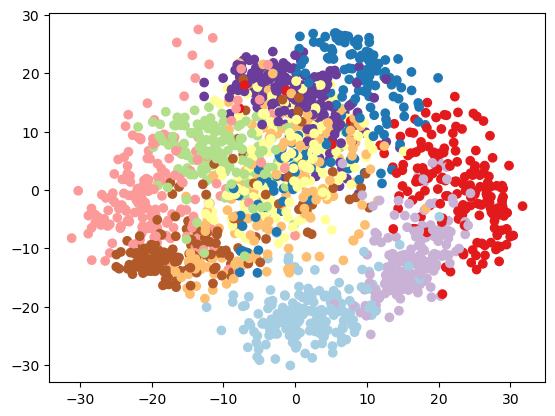

In [21]:
from matplotlib import cm
from sklearn.datasets import load_digits
digits = load_digits()
pca = PCA(n_components=2)
vis = pca.fit_transform(digits.data)
colors = cm.Paired(np.linspace(0., 1., 10))

colors_all = colors[digits.target]
plt.scatter(vis[:, 0], vis[:, 1], c=colors_all)
plt.show()

Dimension two does not seem enough to represent the information of the data since we have clusters overlapping but there is visually some pattern that can give a sense of the variance of the different categories.

### Question 13

Perform a KNN algorithm on the raw data and on the projected data. What do you observe in terms of accuracy?

In [22]:
X_raw = digits.data
y = digits.target
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train_pca, X_test_pca, _, _ = train_test_split(vis, y, test_size=0.3, random_state=42)

knn_raw = KNeighborsClassifier(n_neighbors=10)
knn_raw.fit(X_train_raw, y_train)
y_pred_raw = knn_raw.predict(X_test_raw)
acc_raw = accuracy_score(y_test, y_pred_raw)

knn_pca = KNeighborsClassifier(n_neighbors=10)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"KNN Accuracy on raw data (64D): {acc_raw:.4f}")
print(f"KNN Accuracy on PCA-reduced data (2D): {acc_pca:.4f}")

KNN Accuracy on raw data (64D): 0.9815
KNN Accuracy on PCA-reduced data (2D): 0.6537


Accuracy is lower after PCA which is obvious since we arre projecting a 64 dimensional data to 2 dimension. However the accuacy is not that bad considering the huge reduction we have done.

### Bonus Question

Apply other reduction dimension methods (not seen in class) such as Kernel PCA (choose one kernel), Independant Component Analysis (ICA) and t-SNE. Visualize their projection in dimension two.

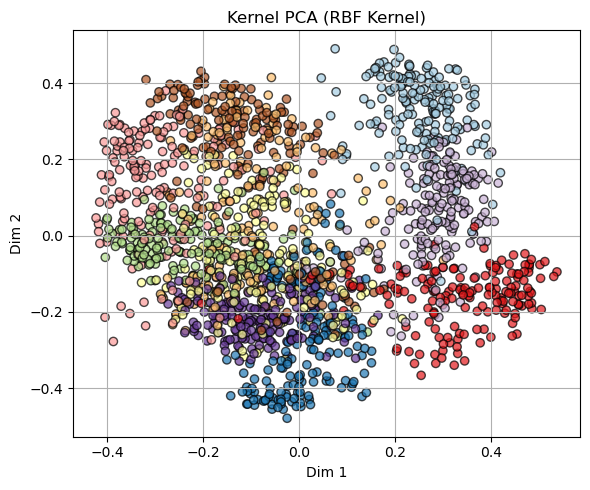

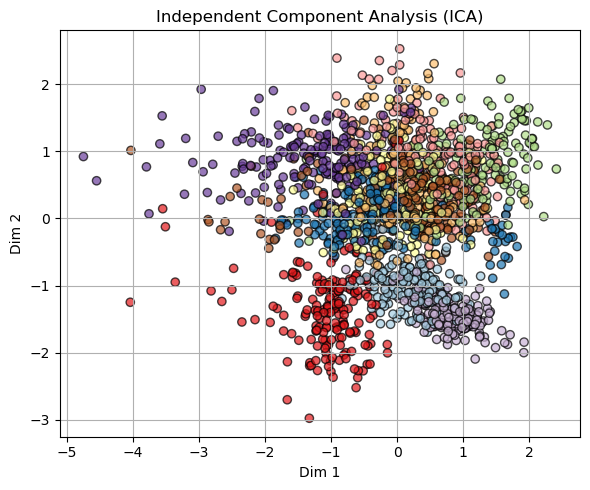

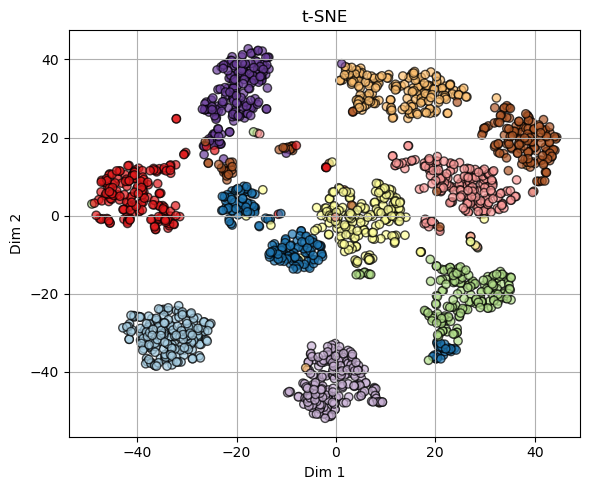

In [23]:
from sklearn.decomposition import FastICA, PCA, KernelPCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

colors = cm.Paired(np.linspace(0., 1., 10))
colors_all = colors[y]

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)
X_kpca = kpca.fit_transform(X_scaled)

ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

def plot_embedding(X, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=colors_all, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid(True)
    plt.tight_layout()

# Plot all projections
plot_embedding(X_kpca, "Kernel PCA (RBF Kernel)")
plot_embedding(X_ica, "Independent Component Analysis (ICA)")
plot_embedding(X_tsne, "t-SNE")

plt.show()

t-SNE performs really good to separate the categories while ICA and Kernel PCA does not give any value visually.